In [4]:
import os
from PIL import Image

# Open test.txt and read the lines
with open(os.path.join(os.pardir, '2_test.txt'), 'r') as file:
  test_items = file.read().splitlines()

images = []

for item in test_items:
  image_path = os.path.join(os.pardir,'dataset', 'ArtDL', 'JPEGImages', f"{item}.jpg")
  try:
    image = Image.open(image_path)
    images.append(image)
  except Exception as e:
    print(f"Error loading image {image_path}: {e}")

print(f"Loaded {len(images)} images")

Loaded 1864 images


Test SigLIP with these models:

* google/siglip-base-patch16-512
* google/siglip-large-patch16-384

In [7]:
from transformers import AutoProcessor, AutoModel
from tqdm import tqdm
import pandas as pd
import torch

model_name = "siglip-base-patch16-512"

model = AutoModel.from_pretrained("google/"+model_name)
processor = AutoProcessor.from_pretrained("google/"+model_name)

# Load classes
with open(os.path.join(os.pardir, 'classes.txt'), 'r') as f:
  classes = [tuple(line.strip().split(',')) for line in f]

all_probs = []
for idx, image in enumerate(tqdm(images)):
  inputs = processor(text=[cls[1] for cls in classes], images=image, padding="max_length", return_tensors="pt")

  with torch.no_grad():
    outputs = model(**inputs)

  logits_per_image = outputs.logits_per_image
  probs = torch.sigmoid(logits_per_image)
  all_probs.append(probs)
  
all_probs = torch.cat(all_probs, dim=0)
print(f"Probabilities shape {all_probs.shape}")

# Convert all_probs to a DataFrame and store it as a CSV file
all_probs_df = pd.DataFrame(all_probs.numpy())
torch.save(all_probs, os.path.join(os.curdir, model_name, 'probs.pt'))


100%|██████████| 1864/1864 [13:14<00:00,  2.35it/s]

Probabilities shape torch.Size([1864, 10])


Number of probabilities in each range:
> 0.0 and <= 0.1: 1304
> 0.1 and <= 0.2: 131
> 0.2 and <= 0.3: 78
> 0.3 and <= 0.4: 49
> 0.4 and <= 0.5: 49
> 0.5 and <= 0.6: 40
> 0.6 and <= 0.7: 33
> 0.7 and <= 0.8: 40
> 0.8 and <= 0.9: 52
> 0.9 and <= 1.0: 88
Probability ranges saved to probability_ranges.csv


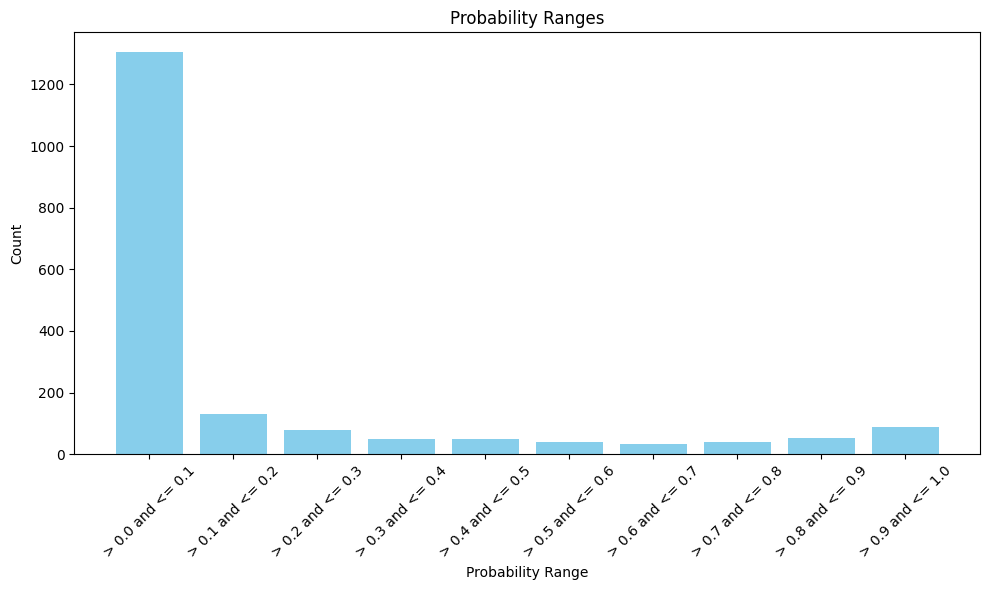

In [42]:
import pandas as pd

ranges = [(i / 10, (i + 1) / 10) for i in range(10)]
range_counts = {f"> {r[0]:.1f} and <= {r[1]:.1f}": 0 for r in ranges}

# Count the number of probabilities in each range
for probs_row in all_probs:
  prob = torch.max(probs_row).item()
  for r in ranges:
    if r[0] < prob <= r[1]:
      range_counts[f"> {r[0]:.1f} and <= {r[1]:.1f}"] += 1

print("Number of probabilities in each range:")
for r, count in range_counts.items():
  print(f"{r}: {count}")
  
# Save the DataFrame to a CSV file
range_counts_df = pd.DataFrame(list(range_counts.items()), columns=['Range', 'Count'])
range_counts_df.to_csv(os.path.join(os.pardir, 'evaluations', 'probability_ranges.csv'), index=False)
print("Probability ranges saved to probability_ranges.csv")
import matplotlib.pyplot as plt

# Plot all columns of the range counts
plt.figure(figsize=(10, 6))
plt.bar(range_counts_df['Range'], range_counts_df['Count'], color='skyblue')
plt.xlabel('Probability Range')
plt.ylabel('Count')
plt.title('Probability Ranges')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import tabulate
import json
from sklearn.metrics import confusion_matrix

output_dir = f'../evaluations/{model_name}'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(os.pardir, '2_ground_truth.json'), 'r') as json_file:
  ground_truth_data = json.load(json_file)
ground_truth_dict = {item['item']: item['class'] for item in ground_truth_data}

class_names = [cls[1] for cls in classes]

threshold = 0.1
y_pred = [
    classes[i.argmax().item()][1] if i.max() >= threshold else "Unclassified"
    for i in all_probs
]

# Create confusion matrix using ground truth and predicted classes
y_true = [ground_truth_dict.get(os.path.basename(item.filename).split('.')[0]) for item in images]
y_true_indices = [class_names.index(cls) for cls in y_true]
y_pred_indices = [class_names.index(cls) for cls in y_pred]
cm = confusion_matrix(y_true_indices, y_pred_indices, labels=range(len(class_names)))

# Populate confusion matrix dictionary
confusion_matrices = {cls: {'TP': 0, 'FP': 0, 'FN': 0} for cls in class_names}
for i, cls in enumerate(class_names):
  confusion_matrices[cls]['TP'] = cm[i, i]
  confusion_matrices[cls]['FP'] = cm[:, i].sum() - cm[i, i]
  confusion_matrices[cls]['FN'] = cm[i, :].sum() - cm[i, i]

# Store dataframe
confusion_matrix_df = pd.DataFrame(confusion_matrices).T
confusion_matrix_df = confusion_matrix_df[['TP', 'FP', 'FN']]

print("Confusion Matrix:")
print(tabulate.tabulate(confusion_matrix_df, headers='keys', tablefmt='pretty'))
confusion_matrix_df.to_csv(os.path.join(output_dir,'confusion_matrix.csv'))

Confusion Matrix:
+-------------------+----+------+------+
|                   | TP |  FP  |  FN  |
+-------------------+----+------+------+
| ANTHONY OF PADUA  | 12 |  44  |  2   |
| JOHN THE BAPTIST  | 68 |  37  |  31  |
|       PAUL        | 0  |  0   |  52  |
| FRANCIS OF ASSISI | 32 |  1   |  66  |
|  MARY MAGDALENE   | 58 |  18  |  32  |
|      JEROME       | 0  |  0   | 118  |
|   SAINT DOMINIC   | 27 | 120  |  2   |
|    VIRGIN MARY    | 91 |  1   | 1098 |
|       PETER       | 0  |  0   | 119  |
|  SAINT SEBASTIAN  | 40 |  11  |  16  |
|   Unclassified    | 0  | 1304 |  0   |
+-------------------+----+------+------+


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Remove 'Unclassified' from class_names
class_names = [cls for cls in class_names if cls != 'Unclassified']

class_image_counts = {cls: 0 for cls in class_names}
for item in y_true:
  class_image_counts[item] += 1

# Convert y_true_indices to one-hot encoding
y_true_one_hot = label_binarize(y_true_indices, classes=range(len(class_names)))

# Calculate precision for each class
class_precisions = precision_score(y_true_indices, y_pred_indices, average=None, labels=range(len(class_names)), zero_division=0) * 100
class_recalls = recall_score(y_true_indices, y_pred_indices, average=None, labels=range(len(class_names)), zero_division=0) * 100
class_f1_scores = f1_score(y_true_indices, y_pred_indices, average=None, labels=range(len(class_names)), zero_division=0) * 100
class_avg_precisions = average_precision_score(y_true_one_hot, all_probs, average=None) * 100

# Store precision, recall, and f1 score for each class into a dataframe
metrics_df = pd.DataFrame({
    'Class Name': class_names,
    '# of Images': [count for count in class_image_counts.values()],
    'Precision': class_precisions,  
    'Recall': class_recalls,        
    'F1 Score': class_f1_scores,    
    'Average Precision': class_avg_precisions 
})

# Reorder the dataframe based on the specified class order
class_order = ["ANTHONY OF PADUA", "FRANCIS OF ASSISI", "JEROME", "JOHN THE BAPTIST", "MARY MAGDALENE", "PAUL", "PETER", "SAINT DOMINIC", "SAINT SEBASTIAN", "VIRGIN MARY"]
metrics_df['Class Name'] = pd.Categorical(metrics_df['Class Name'], categories=class_order + ["MEAN"], ordered=True)
metrics_df = metrics_df.sort_values('Class Name').reset_index(drop=True)

# Add mean values to the dataframe
mean_precision = precision_score(y_true_indices, y_pred_indices, average='macro', zero_division=0) * 100
mean_recall = recall_score(y_true_indices, y_pred_indices, average='macro', zero_division=0) * 100
mean_f1_score = f1_score(y_true_indices, y_pred_indices, average='macro', zero_division=0) * 100
mean_avg_precision = average_precision_score(y_true_indices, all_probs, average='macro') * 100

mean_values = {
    'Class Name': 'Mean',
    '# of Images': '-',
    'Precision': mean_precision,
    'Recall': mean_recall,
    'F1 Score': mean_f1_score,
    'Average Precision': mean_avg_precision
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_values])], ignore_index=True)

metrics_df[['Precision', 'Recall', 'F1 Score', 'Average Precision']] = metrics_df[
    ['Precision', 'Recall', 'F1 Score', 'Average Precision']
].map(lambda x: f"{x:.2f}%")

print("Metrics:")
print(tabulate.tabulate(metrics_df, headers='keys', tablefmt='pretty'))
metrics_df.to_csv(os.path.join(output_dir,'metrics.csv'))

Metrics:
+----+-------------------+-------------+-----------+--------+----------+-------------------+
|    |    Class Name     | # of Images | Precision | Recall | F1 Score | Average Precision |
+----+-------------------+-------------+-----------+--------+----------+-------------------+
| 0  | ANTHONY OF PADUA  |     14      |  21.43%   | 85.71% |  34.29%  |      50.14%       |
| 1  | FRANCIS OF ASSISI |     98      |  96.97%   | 32.65% |  48.85%  |      76.74%       |
| 2  |      JEROME       |     118     |   0.00%   | 0.00%  |  0.00%   |      28.57%       |
| 3  | JOHN THE BAPTIST  |     99      |  64.76%   | 68.69% |  66.67%  |      79.06%       |
| 4  |  MARY MAGDALENE   |     90      |  76.32%   | 64.44% |  69.88%  |      76.91%       |
| 5  |       PAUL        |     52      |   0.00%   | 0.00%  |  0.00%   |      10.14%       |
| 6  |       PETER       |     119     |   0.00%   | 0.00%  |  0.00%   |      27.86%       |
| 7  |   SAINT DOMINIC   |     29      |  18.37%   | 93.10% |